<a href="https://colab.research.google.com/github/Neafiol/Tinkoff/blob/master/GAN/gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

Применение adversarial loss (более общей идеи, лежащей в основе GANов) позволило решить задачи, которые казались невозможными:

* [Машинный перевод без параллельных данных](https://arxiv.org/pdf/1710.11041.pdf)
* [Циклоганы: перевод изображений в другой домен](https://arxiv.org/abs/1703.10593)
* Колоризация и [Super Resolution](https://arxiv.org/abs/1807.02758)
* [Генерация и морфинг произвольных данных](https://arxiv.org/pdf/1809.11096.pdf) ([тут](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/biggan_generation_with_tf_hub.ipynb#scrollTo=HuCO9tv3IKT2) можно поиграться с генерацией бургеров)
* Применения в борьбе с adversarial атаками

Вот постоянно пополняющийся список приложений GANов: https://github.com/nashory/gans-awesome-applications

Сама [статья](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) Яна Гудфеллоу про GANы вышла в конце 2014 года и была процитирована 7687 раз за 4 года.


<img width='500px' src='https://cdn-images-1.medium.com/max/800/1*eWURQXT41pwHvDg1xDiEmw.png'>

Теперь немного формальных определений:

* Пусть $z$ — это вектор из латентного пространства, насэмпленный из нормального распределения.
* $G(z)$ обозначает функцию генератора, которая отображает латентный вектор в пространство данных. Цель $G$ — оценить истинное распределение данных $p_d$, чтобы сэмплировать данные из оцененного распределения $p_g$.
* $D(G(z))$ это вероятность (число от 0 до 1), что выход генератора $G$ является реальным изображением.

$D$ и $G$ играют в минимаксную игру, в которой $D$ старается максимизировать вероятность, что он правильно классифицирует реальные и сгенерированные сэмплы, а $G$ старается минимизировать эту вероятность:

$$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(x)))\big]$$

[Выясняется](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), что решение в этой минимаксной игре достигается при $p_g = p_d$ (и дискриминатор в этом случае может угадывать случайно). В реальности модели не всегда могут сойтись к этой точке.

[DCGAN](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional GAN) называют GAN, который явно использует свёртки и транспонированные свёртки в дискриминаторе и генераторе соответственно. Откройте статью -- мы будем идти очень близко с авторами.

## Датасет
Всем надоели цифры, поэтому обучаться мы будем на датасете CelebA ([Large-scale CelebFaces Attributes](Large-scale CelebFaces Attributes)). В датасете на каждую фотку есть её аттрибуты, но мы их пока использовать не будем.

<img width='500px' src='http://mmlab.ie.cuhk.edu.hk/projects/celeba/overview.png'>

Автор, когда готовил эту тетрадку, долго думал, как загрузить датасет, чтобы всем было удобно. Это оказалось трудно, потому что прямых ссылок на него нигде нет, и, соответственно, просто сделать `!wget ...` нельзя. По удачному стечению обстоятельств, неделю назад кто-то [добавил](https://github.com/pytorch/vision/blob/master/torchvision/datasets/celeba.py) скрипты для загрузки этого датасета в сам `torchvision`, но в `pip` новая версия за такой срок ещё не успела появиться, поэтому мы обновимся напрямую из репозитория на гитхабе:

In [1]:
!pip install git+https://github.com/pytorch/vision.git

  Cloning https://github.com/pytorch/vision.git to /tmp/pip-req-build-66a3zyou
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjdlfzq4/wheels/04/6d/bf/cc14a58bae32d07d1c7d23833dc5ea655e477ff25061b8cd57
Successfully built torchvision
fastai 1.0.50.post1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
  Found existing installation: torchvision 0.2.2.post3
    Uninstalling torchvision-0.2.2.post3:
      Successfully uninstalled torchvision-0.2.2.post3


In [0]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
device = torch.device('cuda:0')  # не забудьте включить GPU

image_size = 64
batch_size = 64

In [4]:
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # Normalize здесь приводит значения в промежуток [-1, 1]
])

dataset = datasets.CelebA('data', download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

1443490838it [00:10, 136780003.95it/s]
26721026it [00:00, 58074252.56it/s]
3424458it [00:00, 140987257.91it/s]
6082035it [00:00, 63760731.96it/s]
12156055it [00:00, 80963102.76it/s]
2836386it [00:00, 131058068.89it/s]


In [5]:
dataset[5][0].shape

torch.Size([3, 64, 64])

In [0]:
# посмотрите на данные (вы писали нужный код в колоризации)
# ...

## Модель

Генератор $G$ преобразует латентный вектор $z$ в пространство данных (в нашем случае -- картинки 3x64x64). В статье используют последовательность блоков из транспонированных свёрток, BatchNorm-ов и ReLU. На выходе каждое значение лежит в [-1, 1] (мы делаем TanH), в соответствии с нормализацией, которую мы сделали раньше.

<img width='600px' src='https://pytorch.org/tutorials/_images/dcgan_generator.png'>

In [0]:
device = torch.device('cuda:0')

In [0]:
num_channels = 3
latent_size = 100
base_size = 64

G = nn.Sequential(
            nn.ConvTranspose2d( latent_size, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        ).to(device)

In [20]:
z = torch.randn(1, latent_size, 1, 1).to(device)
G(z).shape

torch.Size([1, 3, 64, 64])

Дискриминатор -- это обычный бинарный классификатор. В статье он устроен симметрично генератору: Conv2d, BatchNorm, ReLU, Conv2d...

In [0]:
D = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(device)

In [10]:
z = torch.randn(64, latent_size, 1, 1).to(device)
D(G(z.to(device))).shape

torch.Size([64, 1, 1, 1])

In [11]:
for i,_ in loader:
  print(D(i.to(device)).shape)
  break

torch.Size([64, 1, 1, 1])


В статье акцентируют внимание на необходимость нестандартной инициализации весов.

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# apply рекурсивно применяет применяет функцию ко всем своим подмодулям
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Sigmoid()
)

## Обучение

У GANов, помимо сходимости, есть проблема, что их непонятно, как сравнивать между собой, потому что у нас не один лосс, а два. Поэтому полезнее во время обучения смотреть на генерируемые картинки, а не цифры.

In [0]:
def to_numpy_image(img):
    img=img.detach().cpu().view(64, 64,3).numpy()
    return img

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

tensor([[[[0.4740]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


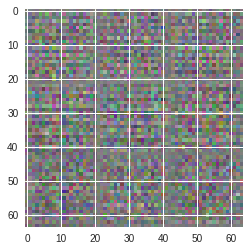

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

tensor([[[[0.4740]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


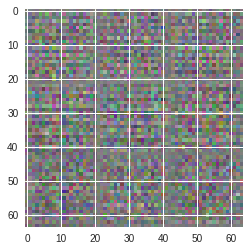

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

tensor([[[[0.4740]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


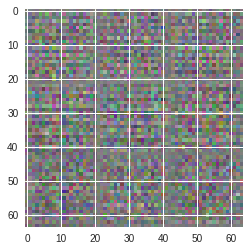

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06

0/10, 0.08883647798742138
  G loss: 14.394767761230469
  D loss: 2.079648766084574e-06



KeyboardInterrupt: ignored

In [22]:
ii = 0
num_epochs = 10
for epoch in range(num_epochs):
  iters = 0
    
  G_ls = []
  D_ls = []
  for data, _ in loader:
    
    y_real = data.to(device)
    #print(y_real.size())
    b_s = y_real.size(0)
    #print(b_s)
    if b_s != 64:
      continue
    D.zero_grad()
    lbl = torch.full((b_s,), 1, device = device)
    #print(lbl)
    out = D(y_real).squeeze()
    lD_real = criterion(out, lbl)
    lD_real.backward()
    
    
    zz = torch.randn(batch_size, latent_size, 1, 1, device=device)
    y_fake = G(zz)
    lbl.fill_(0)
    out = D(y_fake.detach()).squeeze()
    lD_fake = criterion(out, lbl)
    lD_fake.backward()
    lD = lD_real + lD_fake
    optimizerD.step()
    
    
    
    G.zero_grad()
    lbl.fill_(1)
    out = D(y_fake).squeeze()
    lG = criterion(out, lbl)
    lG.backward()
    optimizerG.step()
    
    if iters % 50 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {i/len(loader)}')
            print(f'  G loss: {G_loss}')
            print(f'  D loss: {D_loss}')
            print()
            
    if iters % 200 == 0:
        fake = G(fixed_noise)
        print(D(fake))

        img_list.append(fake)
        img_pred = to_numpy_image(fake)

        plt.figure(figsize=(4,4))
        plt.imshow(img_pred)
        plt.show()
    iters+=1

0/5, 0.0
  G loss: 5.423582553863525
  D loss: 0.0760885551571846

tensor([[[[0.0018]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


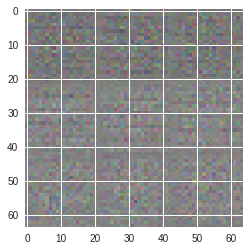

0/5, 0.019654088050314465
  G loss: 12.397494316101074
  D loss: 1.3076032701064833e-05

0/5, 0.03930817610062893
  G loss: 13.125875473022461
  D loss: 2.0520363250398077e-05

0/5, 0.0589622641509434
  G loss: 14.084129333496094
  D loss: 5.427867108664941e-06

0/5, 0.07861635220125786
  G loss: 14.47526741027832
  D loss: 3.007255372722284e-06

tensor([[[[1.6925e-07]]]], device='cuda:0', grad_fn=<SigmoidBackward>)


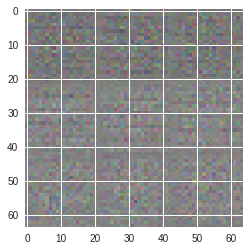

KeyboardInterrupt: ignored

In [16]:
fixed_noise=torch.randn(1, latent_size, 1, 1).to(device)
batch_size =64

num_epochs = 5
learning_rate = 2e-4

img_list = []
G_losses = []
D_losses = []

optimizerD = optim.Adam(D.parameters(), lr=learning_rate,betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=learning_rate,betas=(0.5, 0.999))

criterion = nn.BCELoss().to(device)
i=0
for epoch in range(num_epochs):
    for (data, _) in loader:

        # train with real
        if data.shape[0]!=batch_size:
          continue
        data=data.to(device)
        
        
        D.zero_grad()        
        label = torch.full((batch_size,), 1, device=device)
        output = D(data).squeeze()
        D_loss1 = criterion(output, label)
        D_loss1.backward()

        # train with fake
        z = torch.randn(batch_size, latent_size, 1, 1).to(device)
        fake_photos = G(z)
        label.fill_(0)
        output = D(fake_photos.detach()).squeeze()
        D_loss2 = criterion(output, label)
        D_loss2.backward()

        D_loss = D_loss1 + D_loss2
        optimizerD.step()


        G.zero_grad()
        label.fill_(1)  
        output = D(fake_photos.detach()).squeeze()
        G_loss = criterion(output, label)
        G_loss.backward()
#         torch.nn.utils.clip_grad_value_(G.parameters(), 2.5)
        optimizerG.step()
        
        if i % 50 == 0:
            # Выведем информацию о том, как наша сеть справляется
            print(f'{epoch}/{num_epochs}, {i/len(loader)}')
            print(f'  G loss: {G_loss}')
            print(f'  D loss: {D_loss}')
            print()
            
        if i % 200 == 0:
            fake = G(fixed_noise)
            print(D(fake))
            
            img_list.append(fake)
            img_pred = to_numpy_image(fake)

            plt.figure(figsize=(4,4))
            plt.imshow(img_pred)
            plt.show()
        i+=1
   
        



In [0]:
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))

In [0]:
img_pred = to_numpy_image(img_list[0])
    # теперь это numpy-евский ndarray размера (128, 128, 3)
plt.figure(figsize=(10,10))
plt.imshow(img_pred)

In [0]:
plt.figure(figsize=(10,5))
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
# распечатайте ваши картинки

### Что дальше?

Довольно старый, но актуальный список трюков: https://github.com/soumith/ganhacks

Вообще, теория сходимости GANов очень сильно развилась за последнее время. Если хотите во всём этом разобраться, то возьмите какую-нибудь [достаточно новую статью](https://arxiv.org/pdf/1802.05957.pdf) и рекурсивно почитайте оттуда абстракты из списока литературы.